In [5]:
%load_ext pycodestyle_magic
%pycodestyle_on
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msgno

from scikeras.wrappers import KerasClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

2022-10-21 18:28:36.868017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 18:28:36.868033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
df = pd.read_csv('smoke_detection_iot.csv')

# Pre Processing Data:

In [7]:
df.head(5)

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [8]:
df.dtypes

Unnamed: 0          int64
UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT                 int64
Fire Alarm          int64
dtype: object

## Change columns names:

In [9]:
%pycodestyle_off
dict_names = {'Humidity[%]' : 'Humidity',
              'Temperature[C]' : 'Temperature',
              'TVOC[ppb]' : 'TVOC',
              'eCO2[ppm]' : 'ECO2',
              'Pressure[hPa]' : 'Pressure'}
%pycodestyle_on
df.rename(columns = dict_names, inplace = True)

In [10]:
df = df.drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)

## Looking for NaN values:

In [11]:
df.isna().sum()

Temperature    0
Humidity       0
TVOC           0
ECO2           0
Raw H2         0
Raw Ethanol    0
Pressure       0
PM1.0          0
PM2.5          0
NC0.5          0
NC1.0          0
NC2.5          0
Fire Alarm     0
dtype: int64

<AxesSubplot:>

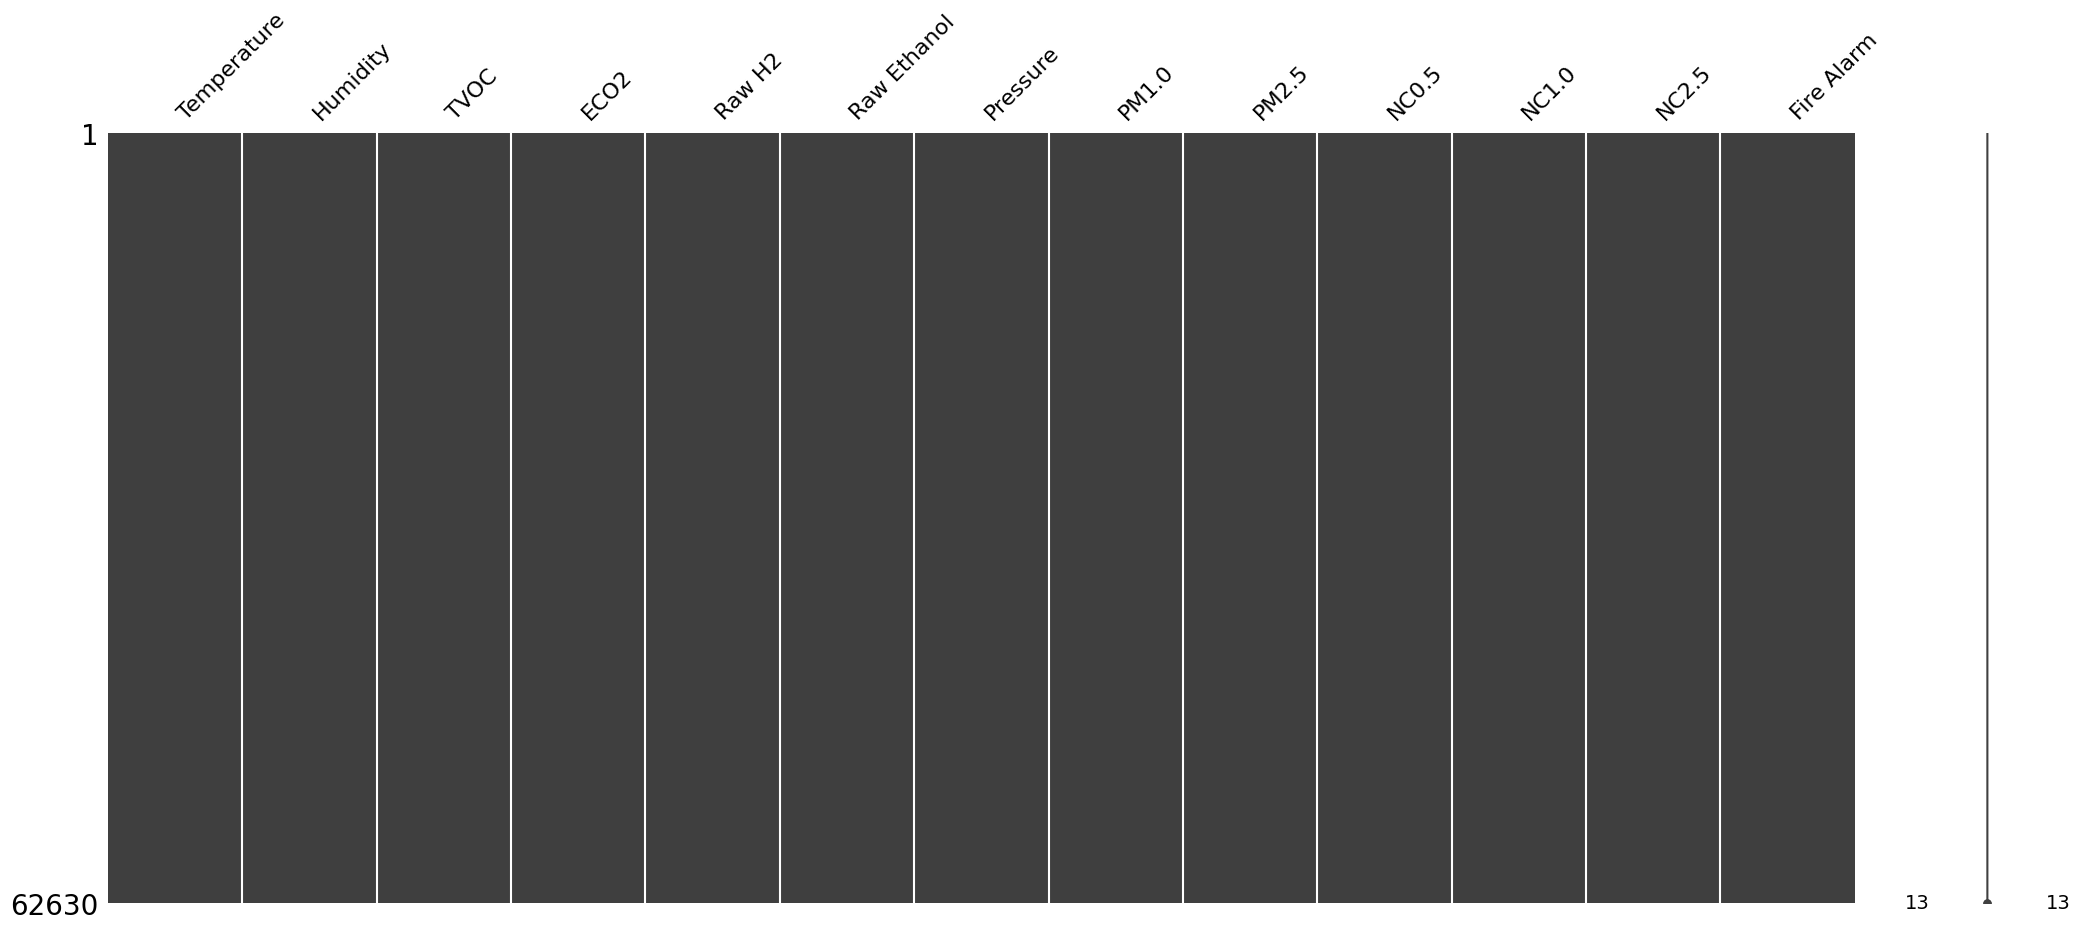

In [12]:
msgno.matrix(df)

#### There is no missing data.

</br>

## Ploting the correlation matrix, to get the correlation between columns:

<AxesSubplot:>

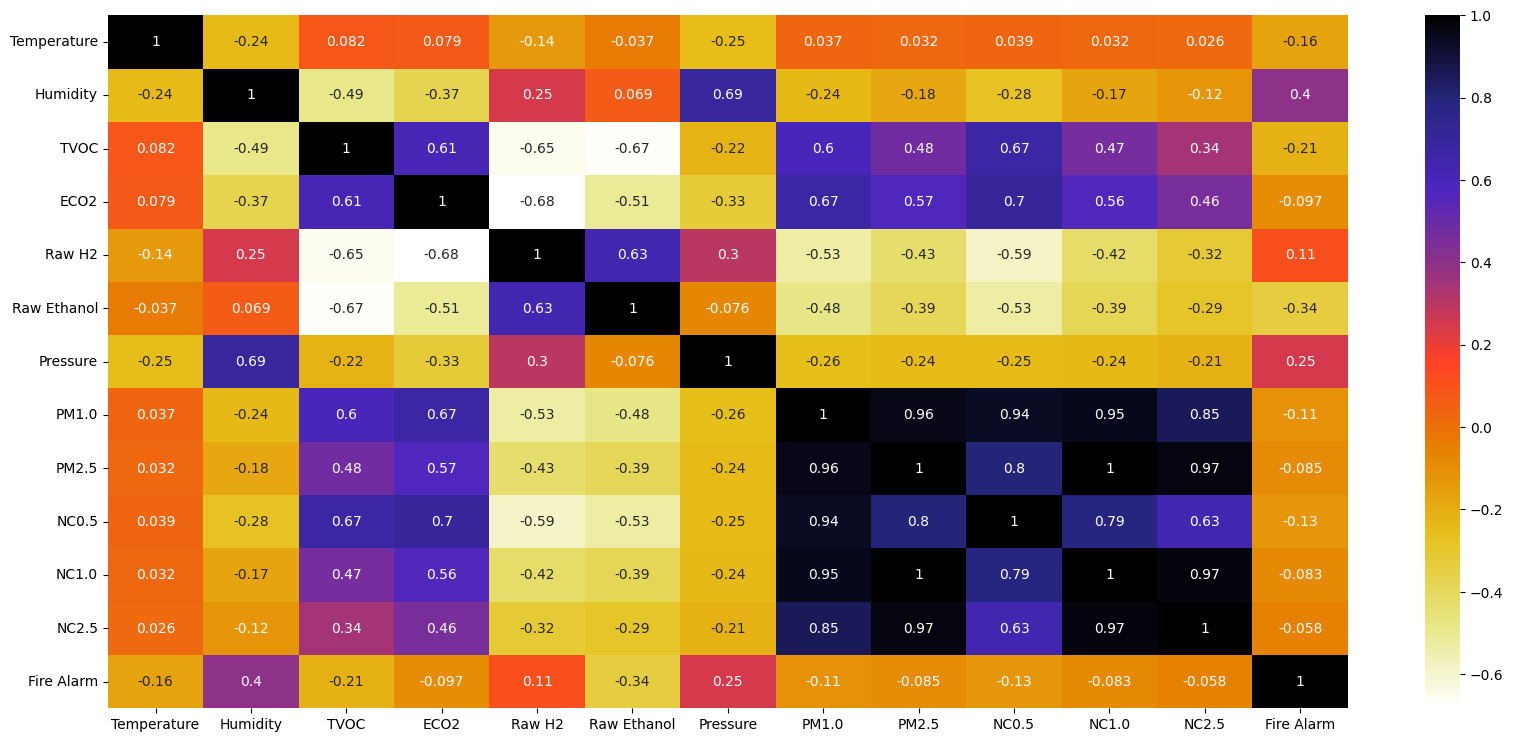

In [13]:
corr = df.corr()  # Obtaine correlation between columns.
plt.figure(figsize=(20, 9))
sns.heatmap(corr, annot=True, cmap=plt.cm.CMRmap_r)

### From the plot, we can conlude that PM and NC are highly correlated between them. So, we are droping some of them, to avoid multicollinearity. 

### We are droping PM1.0, NC1.0, NC2.5, NC0.5

In [14]:
df = df.drop(['NC1.0', 'NC0.5', 'NC2.5', 'PM1.0'],
             axis=1)
df.columns

Index(['Temperature', 'Humidity', 'TVOC', 'ECO2', 'Raw H2', 'Raw Ethanol',
       'Pressure', 'PM2.5', 'Fire Alarm'],
      dtype='object')

## Create model:

In [34]:
def ccmodel():
    n_features = 8
    my_model = tf.keras.models.Sequential()
    my_model.add(tf.keras.layers.Dense(units=1, input_shape=(n_features, ),
                                       activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.05)

    my_metric = [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy',
                                                 threshold=0.55)]

    my_model.compile(opt, loss='binary_crossentropy',
                     metrics=my_metric)
    return my_model

## Data has a wide range of values, so we scale it.
### We are using a pipeline to scale the data and train our model.

In [16]:
NUMERICAL_FEATURES = df.columns.tolist()
NUMERICAL_FEATURES.remove('Fire Alarm')

preprocess = ColumnTransformer(
                transformers=[
                      ("process", StandardScaler(), NUMERICAL_FEATURES)])

In [17]:
NUMERICAL_FEATURES

['Temperature',
 'Humidity',
 'TVOC',
 'ECO2',
 'Raw H2',
 'Raw Ethanol',
 'Pressure',
 'PM2.5']

In [35]:
model = Pipeline(
    steps=[
        ('preprocessor', preprocess),
        ('classifier',  KerasClassifier(model=ccmodel, epochs=25,
                                        batch_size=32,
                                        validation_split=0.2))
    ],
    verbose=True
)

X = df.drop('Fire Alarm', axis=1)
y = df['Fire Alarm'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
Epoch 1/25
1253/1253 [==============================] - 1s 566us/step - loss: 0.2337 - binary_accuracy: 0.8893 - val_loss: 0.2108 - val_binary_accuracy: 0.9021
Epoch 2/25
1253/1253 [==============================] - 1s 510us/step - loss: 0.2110 - binary_accuracy: 0.9013 - val_loss: 0.2124 - val_binary_accuracy: 0.9048
Epoch 3/25
1253/1253 [==============================] - 1s 494us/step - loss: 0.2083 - binary_accuracy: 0.9010 - val_loss: 0.2119 - val_binary_accuracy: 0.9097
Epoch 4/25
1253/1253 [==============================] - 1s 513us/step - loss: 0.2067 - binary_accuracy: 0.9001 - val_loss: 0.2131 - val_binary_accuracy: 0.9079
Epoch 5/25
1253/1253 [==============================] - 1s 502us/step - loss: 0.2064 - binary_accuracy: 0.8999 - val_loss: 0.2080 - val_binary_accuracy: 0.9006
Epoch 6/25
1253/1253 [==============================] - 1s 533us/step - loss: 0.2049 - binary_accuracy: 0.8998 - val_loss: 0.2079

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('process', StandardScaler(),
                                                  ['Temperature', 'Humidity',
                                                   'TVOC', 'ECO2', 'Raw H2',
                                                   'Raw Ethanol', 'Pressure',
                                                   'PM2.5'])])),
                ('classifier',
                 KerasClassifier(batch_size=32, epochs=25, model=<function ccmodel at 0x7f0b0473e560>, validation_split=0.2))],
         verbose=True)

In [36]:
model.score(X_test, y_test)

392/392 [==============================] - 0s 283us/step


0.8921443397732716

In [37]:
y_pred = model.predict(X_test)

392/392 [==============================] - 0s 273us/step


In [40]:
col_names = ['Positive_Pred', 'Negative_Pred']
row_names = ['Positive_Act', 'Negative_Act']
matrix = confusion_matrix(y_test, y_pred)
better_conf_matrix = pd.DataFrame(matrix, columns=col_names, index=row_names)
better_conf_matrix

,Positive_Pred,Negative_Pred
Positive_Act,2737,855
Negative_Act,496,8438


In [41]:
classification_report(y_test, y_pred, output_dict=True)
display(pd.DataFrame.from_dict(
    classification_report(
        y_test,
        y_pred,
        output_dict=True)).T)

,precision,recall,f1-score,support
0,0.846582,0.761971,0.802051,3592.000000
1,0.907995,0.944482,0.925879,8934.000000
accuracy,0.892144,0.892144,0.892144,0.892144
macro avg,0.877289,0.853226,0.863965,12526.000000
weighted avg,0.890384,0.892144,0.890370,12526.000000


In [42]:
y_prob = model.predict_proba(X_test)

392/392 [==============================] - 0s 270us/step


In [43]:
y_prob_positive = y_prob[:, 1]
y_prob_positive

array([0.9941015 , 0.9756889 , 0.9946155 , ..., 0.95920986, 0.99966127,
       0.9312565 ], dtype=float32)

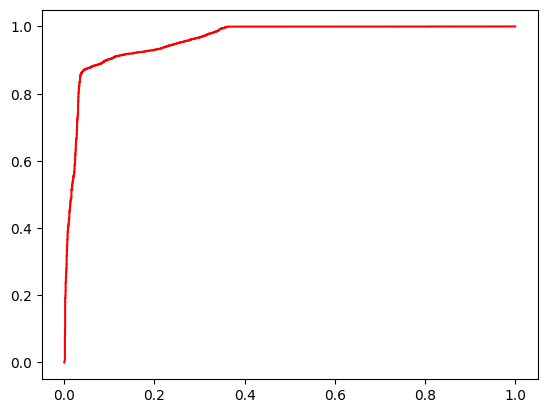

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_positive)


def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='red', label='ROC')


plot_roc_curve(fpr, tpr)